In [265]:
from fbprophet import Prophet
from scipy.linalg import toeplitz

In [139]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
weather = pd.read_csv('data/weather.csv')

In [3]:
test['units']=np.nan

In [34]:
len(train), len(test)

(4617600, 526917)

In [40]:
merged = pd.concat([train, test])
merged = merged.sort_values(by=['date','store_nbr','item_nbr'])
merged['date'] = pd.to_datetime(merged['date'])
merged['year'] = merged['date'].dt.year
merged['month'] = merged['date'].dt.month
merged['day'] = merged['date'].dt.day
merged['week'] = merged.date.dt.week

In [4]:
len(test), len(train), len(weather)

(526917, 4617600, 20517)

In [5]:
train.isna().sum()

date         0
store_nbr    0
item_nbr     0
units        0
dtype: int64

In [6]:
test.isna().sum()

date              0
store_nbr         0
item_nbr          0
units        526917
dtype: int64

In [11]:
weather.isna().sum()

station_nbr    0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
dtype: int64

In [12]:
weather2 = weather.replace('-', np.nan) 
weather2 = weather2.replace('T', 0)

In [13]:
weather2

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,NaN,NaN,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8
5,7,2012-01-01,50,33,42,M,26,35,23,0,NaN,NaN,,0.0,0.00,29.15,30.54,10.3,32,10.2
6,8,2012-01-01,66,45,M,M,34,46,M,M,NaN,NaN,RA BR,M,0.00,30.05,M,11.0,36,10.9
7,9,2012-01-01,34,19,27,M,17,23,38,0,NaN,NaN,UP,M,T,29.34,30.09,22.8,30,22.5
8,10,2012-01-01,73,53,63,M,55,58,2,0,0723,1738,FG+ FG BR,M,0.00,30.16,30.19,5.1,24,5.5
9,11,2012-01-01,72,48,60,7,54,56,5,0,0724,1737,FG+ FG BR,0.0,0.00,30.15,30.18,4.6,23,4.8


In [124]:
def get_store(n):
    return merged[merged['store_nbr']==n]

In [168]:
# 판매된 아이템만 찾기
def get_nonzero_item():
    for n in range(1, 46):
        s1 = get_store(n)
        nonzero = s1.pivot_table(index='item_nbr', aggfunc=np.sum).reset_index()
        nonzero = nonzero[nonzero['units']>0]
        print(n, nonzero['item_nbr'].values)
    
get_nonzero_item()

1 [ 9 28 40 47 51 89 93 99]
2 [ 5 11 44 85 93]
3 [  2   5  45  93 102 109]
4 [  9  27  90  93  96  97 101]
5 [ 16  20  32  37  93 105]
6 [  9  14  45 107]
7 [ 5  7 23 93 95]
8 [  5  23  59  84  93 100]
9 [  5  10  42  45  93 105]
10 [ 5 21 37 86 93]
11 [  9  61  68  86  87 110]
12 [16 37 79 86 93]
13 [  5  36  46  93 104]
14 [ 9 15 25 33 50 70 88 93]
15 [ 5 15 17 45 49 61 86 93]
16 [16 25 39 50 64 77 85 93]
17 [ 9 37 48 71]
18 [ 5 37 57 72]
19 [15 16 39 69 75 83 88 93]
20 [  5  18  41  74  93 106]
21 [  5  44  91 109]
22 [  9  54  68  78  93 104]
23 [ 5 29 45 56]
24 [ 6 43 60 76 97]
25 [ 9 12 45 50 81 84 93]
26 [ 2  5 45]
27 [ 9 21 68 80 93]
28 [ 2  5 35 45]
29 [ 8 41 45 56]
30 [13 16 44 49 51 65]
31 [  9  45  67  93  98 104]
32 [ 9 19 45 51 58 86 93]
33 [ 9 44 85 92 93]
34 [ 9 31 45 52 84 93]
35 [ 16  24  49  50  63  66  93 105]
36 [ 1  9 30 44]
37 [  5  15  38  45  53 104 105]
38 [ 9 45 52 86 93 98]
39 [  9  36 103 111]
40 [  5  15  45  51  55  93 106]
41 [ 16  61  68  86  93 108]
42

In [201]:
def get_store_item(n, item):
    s1 = get_store(n)
    i9 = s1[s1['item_nbr']==item].reset_index(drop=True)
    i9['istest'] = 0
    i9['istest'][i9['units'].isna()] = 100

    plt.figure(figsize=(20, 2))
    plt.plot(i9['date'], i9['istest'])
    plt.show()

    for year in [2012, 2013, 2014]:
        i92012 = i9[i9['year']==year]
        x = i92012['date']
        y = i92012['istest']
        plt.figure(figsize=(20, 2))
        plt.plot(x, y)
        plt.plot(x, i92012['units'])
        plt.show()
    return i9

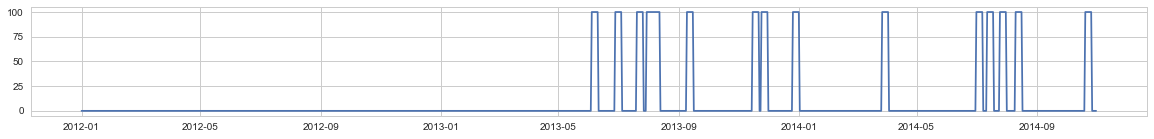

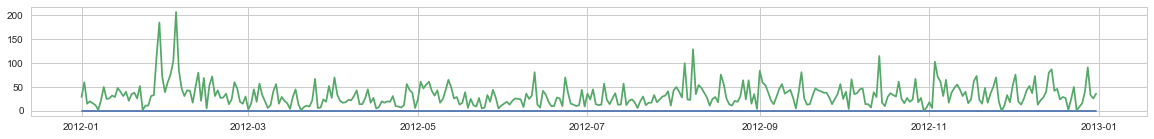

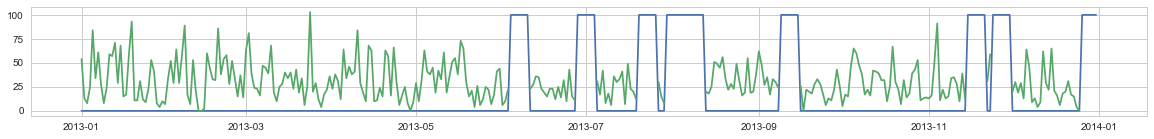

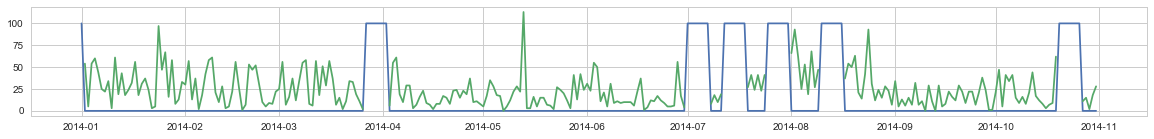

In [821]:
i9 = get_store_item(1, 9)

In [822]:
testday = i9[i9['units'].isna()]
testday = testday.reset_index()

In [823]:
testday['diff'] = testday['date'].diff()
testday['diff'][0]='1 days'
testday['diff'] = testday['diff'].dt.days
testday['diff'][0] = 2

In [824]:
start_days = testday.loc[testday[testday['diff']>1].index]['date'].rename(columns={'date':'start'})

In [825]:
end_days = testday.loc[testday[testday['diff']>1].index-1]['date']
end_days = end_days.drop(-1)
end_days.loc[testday.index[-1]]=testday['date'][len(testday)-1]
end_days = end_days.rename(columns={'date':'end'}) 

In [826]:
diff_day = pd.concat([start_days.reset_index(drop=True), end_days.reset_index(drop=True)], axis=1).rename(columns={0:'start', 1:'end'})
diff_day['day'] = (diff_day['end'] - diff_day['start']).dt.days

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


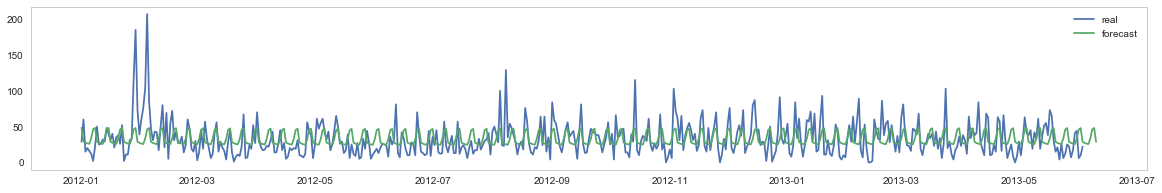

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


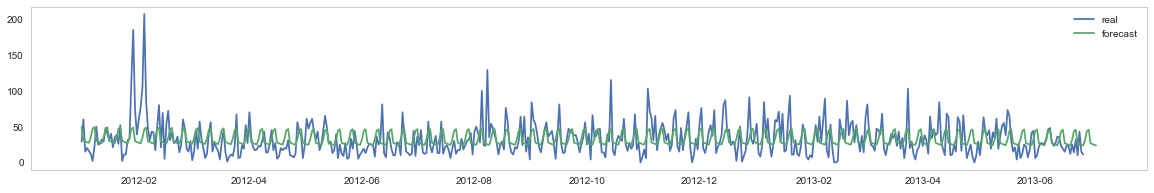

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


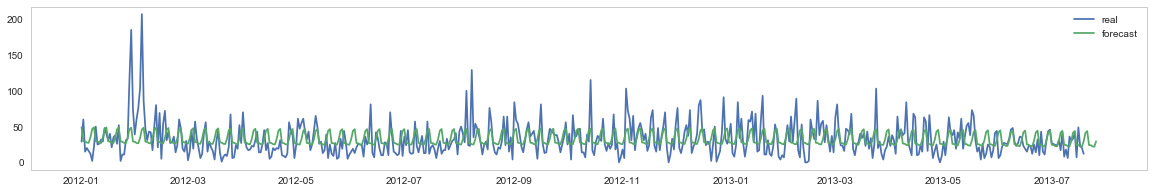

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


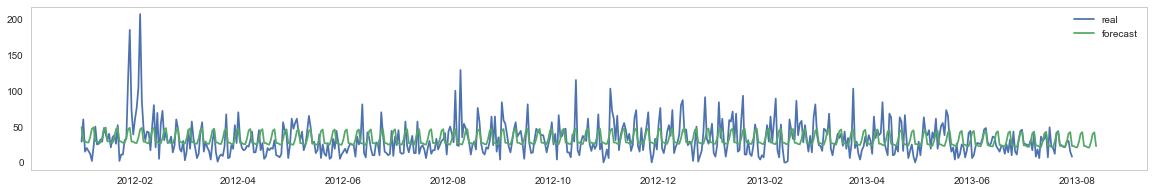

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


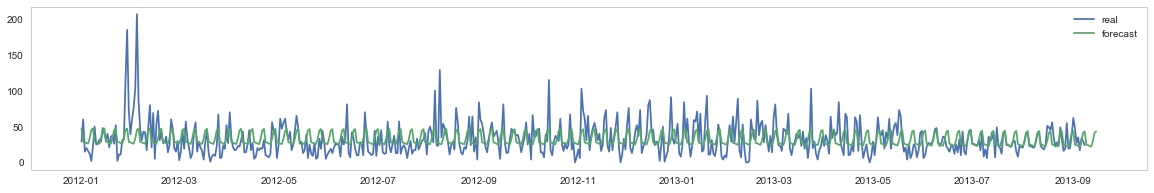

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


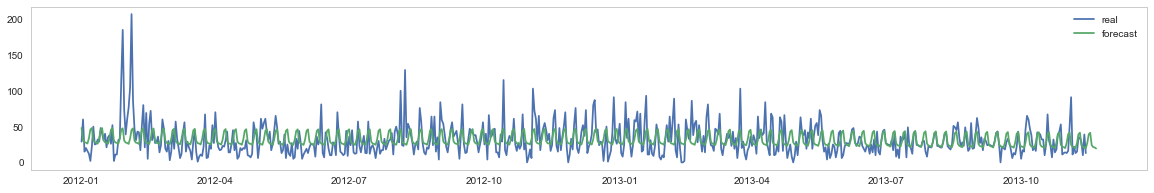

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


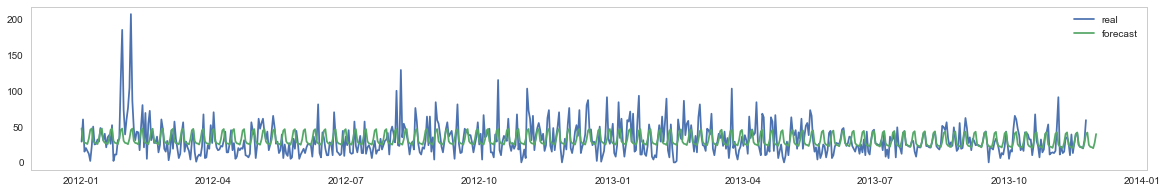

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


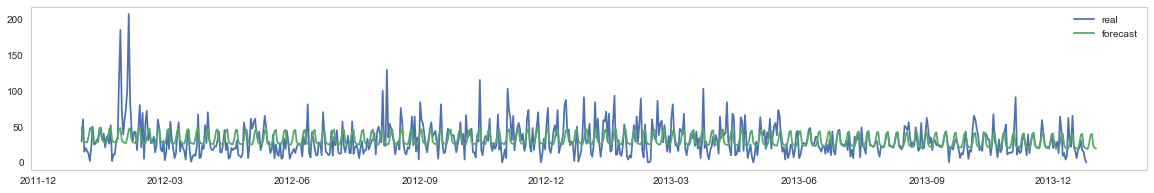

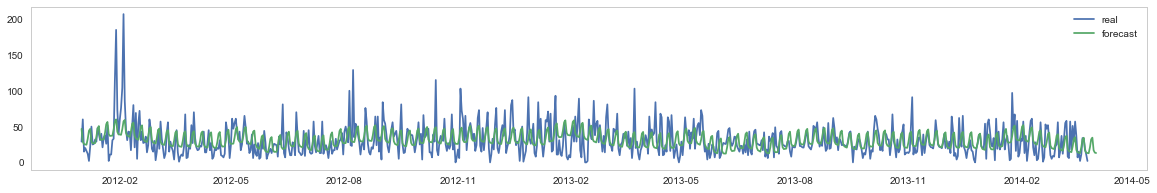

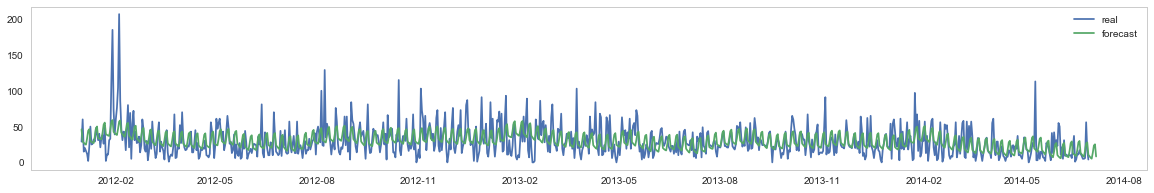

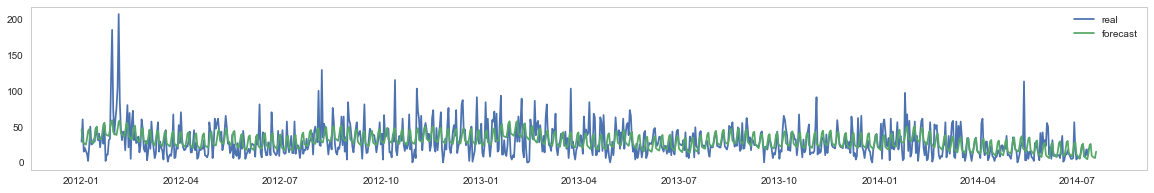

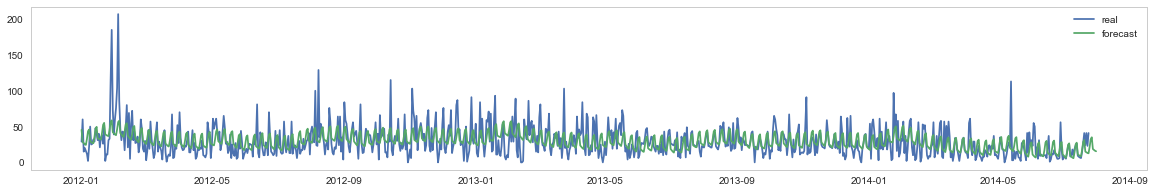

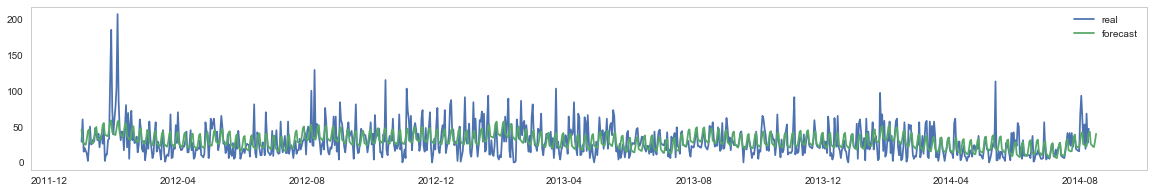

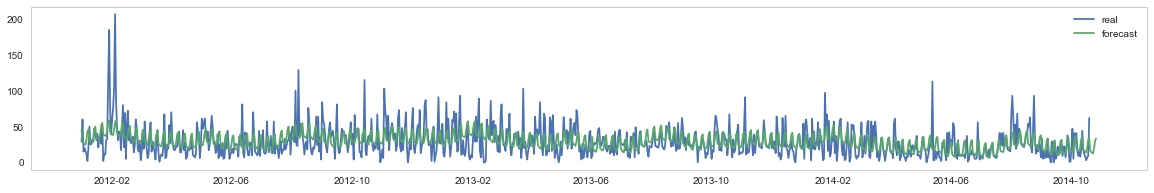

In [861]:

for i in range(len(diff_day)):
    day_row = diff_day.iloc[i]
    start, end, day = day_row['start'], day_row['end'], day_row['day'] +1
    
    df = i9[i9['date']<start][['date', 'units']].rename(columns={'date':'ds','units':'y'})
    
    m = Prophet(daily_seasonality=True)
    m.fit(df);
    
    future = m.make_future_dataframe(periods=day)
    forecast = m.predict(future)
    
    testidx = i9[(i9['date']>=start) & (i9['date']<=end)].index
    i9['units'].loc[testidx] = forecast['yhat'][-day:]
    
    plt.figure(figsize=(20,3))
    plt.plot(df['ds'], df['y'], label='real') 
    plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
    plt.grid()
    plt.legend()
    plt.show() 
#     break

In [862]:
start

Timestamp('2014-10-20 00:00:00')

In [863]:
end

Timestamp('2014-10-26 00:00:00')

In [864]:
day

7

In [865]:
i9

,date,store_nbr,item_nbr,units,year,month,day,week,istest
0,2012-01-01,1,9,29.000000,2012,1,1,52,0
1,2012-01-02,1,9,60.000000,2012,1,2,1,0
2,2012-01-03,1,9,15.000000,2012,1,3,1,0
3,2012-01-04,1,9,20.000000,2012,1,4,1,0
4,2012-01-05,1,9,16.000000,2012,1,5,1,0
5,2012-01-06,1,9,12.000000,2012,1,6,1,0
6,2012-01-07,1,9,2.000000,2012,1,7,1,0
7,2012-01-08,1,9,22.000000,2012,1,8,1,0
8,2012-01-09,1,9,50.000000,2012,1,9,2,0
9,2012-01-10,1,9,25.000000,2012,1,10,2,0


In [852]:
df = i9[(i9['date']<'2013-06-04')][['date', 'units']].rename(columns={'date':'ds','units':'y'})

In [853]:
m = Prophet(daily_seasonality=True)
m.fit(df);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [854]:
future = m.make_future_dataframe(periods=30)

In [855]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
544,2013-06-29,46.065854,17.741127,74.598708
545,2013-06-30,48.026151,17.519145,74.398649
546,2013-07-01,28.746509,-0.312563,57.072532
547,2013-07-02,27.293875,-0.393438,55.373901
548,2013-07-03,26.315170,-1.825629,56.283721


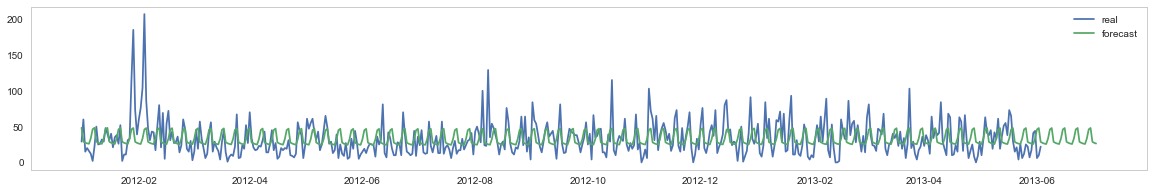

In [856]:
plt.figure(figsize=(20,3))
plt.plot(df['ds'], df['y'], label='real')

plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

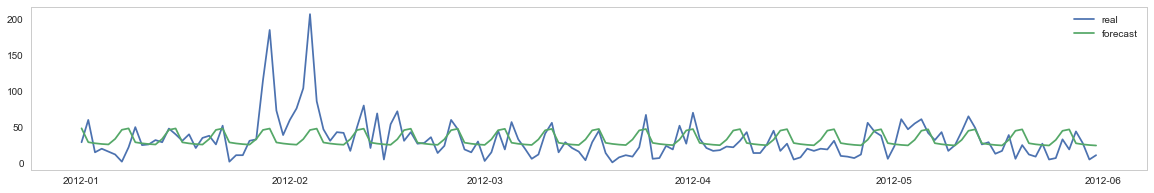

In [857]:
plt.figure(figsize=(20,3))
plt.plot(df[df['ds']<'2012-06-01']['ds'], df[df['ds']<'2012-06-01']['y'], label='real')
plt.plot(forecast[forecast['ds']<'2012-06-01']['ds'], forecast[forecast['ds']<'2012-06-01']['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()